In [11]:
import numpy as np
import spreadingcode as sc
import matplotlib.pyplot as plt

# get no-delay spreading code 
c_LR = sc.PRN(1)

# make a function to sample this 

def sample_sequence(prn_sequence, sampling_rate):
    # Determine the number of samples per chip
    #samples_per_chip = int(sampling_rate / len(prn_sequence))
    chip_rate = 1.023e6 # chips/1s 
    samples_per_chip = int(sampling_rate/ chip_rate)
    print(samples_per_chip)

    # Repeat each element of the PRN sequence 'samples_per_chip' times
    sampled_sequence = np.repeat(prn_sequence, samples_per_chip)
    
    # encode into -1s and 1s 
    sampled_sequence[np.nonzero(sampled_sequence)] = -2
    sampled_sequence = sampled_sequence + 1

    return sampled_sequence

# Assuming you already have the PRN sequence generated and stored in 'prn_sequence'
prn_sequence = sc.PRN(1)

# Sample the PRN sequence at 2 times the PRN chip rate
sampling_rate = 10e6 # 10 Mhz sampling rate 
sampled_sequence = sample_sequence(prn_sequence, sampling_rate)

# The 'sampled_sequence' now contains the PRN sequence sampled at the desired rate

def calculate_acf(sequence):
    # when using np.correlate with the same sequence, the ACF is produced
    acf = np.correlate(sequence, sequence, mode='full')
    return acf

sampled_ACF = calculate_acf(sampled_sequence)

def plot_acf(acf, sampling_rate, samples_around_peak=100):
    # Find the index of the peak (maximum) value in the ACF
    peak_index = np.argmax(acf)

    print(peak_index)

    # Calculate the delay range to plot around the peak
    start_delay = max(0, peak_index - samples_around_peak // 2)
    end_delay = min(len(acf), peak_index + samples_around_peak // 2)

    # Create a range of delays for the plot
    delays = np.arange(start_delay, end_delay)

    # Convert the delay values to represent chips instead of samples
    delays_in_chips = np.arange(start_delay, end_delay) / samples_per_chip - 1023

    print("%i Samples Plotted," % len(delays_in_chips))

    plt.stem(delays_in_chips, acf[delays], use_line_collection=True)
    plt.xlabel('Delay (chips)')
    plt.ylabel('ACF Value')
    plt.title('Autocorrelation Function (ACF) with Sampling Rate: {} Hz'.format(sampling_rate))
    plt.grid(True)
    plt.show()



9


9206
250 Samples Plotted,


C:\Users\logan\AppData\Local\Temp\ipykernel_32744\1185030562.py:60: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(delays_in_chips, acf[delays], use_line_collection=True)


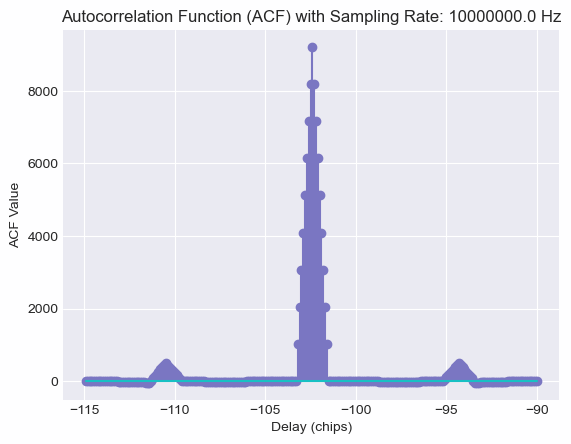

In [12]:
# Assuming you have already computed 'sampled_ACF'
# and you want to save it to a file called 'sampled_ACF.npy'
np.save('sampled_ACF.npy', sampled_ACF)

# To load the saved array back into your script
loaded_sampled_ACF = np.load('sampled_ACF.npy')

# Apply the style guide
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

plot_acf(sampled_ACF, sampling_rate, 250)

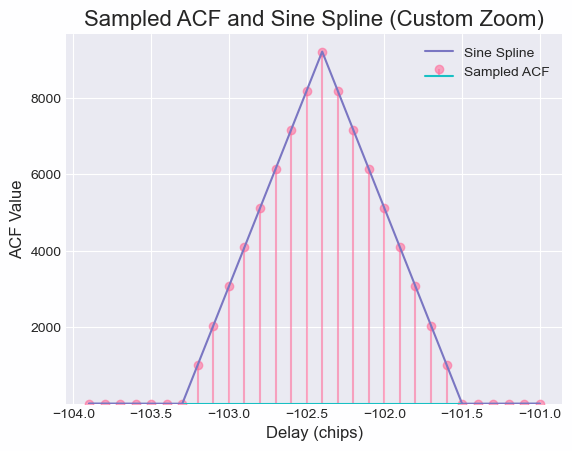

30 Samples Plotted


In [8]:
from scipy.interpolate import UnivariateSpline

# apply a sine spline to the sampled region around the ACF peak to show sampling effect

def plot_acf_with_custom_zoom(sampled_ACF, peak_index, num_points_around_peak, samples_per_chip):
    # Calculate the starting and ending indices for the zoomed region around the peak
    start_delay = max(0, peak_index - num_points_around_peak // 2)
    end_delay = min(len(sampled_ACF), peak_index + num_points_around_peak // 2)

    # pull only specific region
    #acf_range = np.arange(start_delay, end_delay)
    acf_range = np.arange(start_delay, end_delay)
    ACF_region = sampled_ACF[acf_range]
    spline = UnivariateSpline(acf_range, ACF_region, k=5, s=0)

    # Convert the delay values to represent chips instead of samples
    delays_in_chips = np.arange(start_delay, end_delay) / samples_per_chip - 1023

    #  Set y-axis lower limit to the value of the last data point
    fig, ax = plt.subplots()  # Create a subplot

    ax.stem(delays_in_chips, ACF_region, linefmt='C1-', label='Sampled ACF')  # White line for ACF
    ax.plot(delays_in_chips, spline(acf_range), label='Sine Spline')  # Red line for spline
    # for plots, use color='C0' etc... to move through pallete

    # Set y-axis lower limit to the value of the last data point
    ax.set_ylim(bottom=ACF_region[-1])

    ax.set_xlabel('Delay (chips)', fontsize=12)  # Set x-axis label color and font size
    ax.set_ylabel('ACF Value', fontsize=12)  # Set y-axis label color and font size
    ax.set_title('Sampled ACF and Sine Spline (Custom Zoom)', fontsize=16)  # Set title color and font size
    ax.legend(fontsize=10, loc='upper right')  # Set legend font size and location

    # # Set grid color to darker gray and use dashed lines
    # ax.grid(True, color='dimgray', linestyle='--')  

    # Set the color of the tick labels on the axes to white
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    plt.show()

    print("%i Samples Plotted" % len(delays_in_chips))

# Assuming you have 'sampled_ACF', 'spline', 'peak_index' from previous steps
peak_index = np.argmax(np.abs(sampled_ACF))
num_points_around_peak = 30  # Adjust the number of points as desired

# Apply the style guide
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

plot_acf_with_custom_zoom(sampled_ACF, peak_index, num_points_around_peak, samples_per_chip)


